# **Spatiotemporal demand forecasting with neural networks**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import (
    load_data, 
    summarize_data, summary_plots, map_hotspot,
    grid_data, widen_grid_data, make_3d_array,
    plot_timeseries_cells,
    plot_grid, split_and_standarize_data,
    WindowGenerator, compile_and_fit, make_ypred
)
from constants import BATCH_SIZE, MAX_EPOCHS, NROW, NCOL

### **Get data**

The data consists of X-Y-t (longitude, latitude, time) coordinates of demand events. The goal is to create models that can predict the spatiotemporal distribution of these events in the near future.

In [2]:
demand = load_data('data/demand.csv')

In [3]:
demand.head()

,start_lat,start_lng
start_time,,
2022-03-06 15:02:39.329452,59.407910,24.689836
2022-03-10 11:15:55.177526,59.441650,24.762712
2022-03-06 14:23:33.893257,59.435404,24.749795
2022-03-03 09:11:59.104192,59.406920,24.659006
2022-03-06 00:13:01.290346,59.434940,24.753641


### **Explore data**

In [4]:
summarize_data(demand)

Total no. events = 627,210
Time range = 2022-03-01 00:00 - 2022-03-28 23:59


Spatiotemporal distribution of events shows daily activity pattern and strong concentration in a hotspot. Slight increase from Mo. to Sa., and over the weeks of March. Last week is incomplete (!). 

**Not possible to assess/model seasonal pattern (winter-spring-summer-autumn) with just one month, as well as multi-annual trends.**

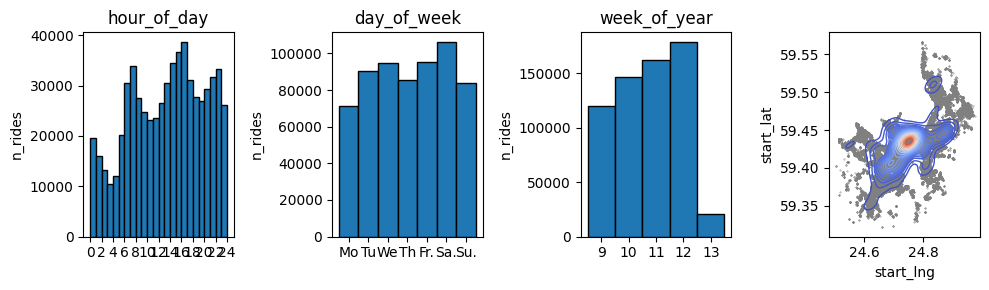

In [5]:
summary_plots(demand)

Zooming in to the downtown hotspot doesn't show any further spatial structure

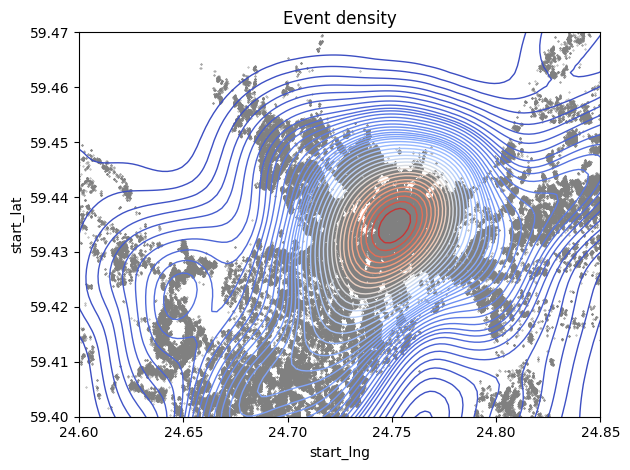

In [6]:
map_hotspot(demand)

### **Feature engineering - `n_events`**

The original continuous dataset can be grouped into temporal and lat-long bins to create a discrete spatiotemporal distribution of event counts -> `n_events`

In [4]:
gridded_data = grid_data(demand, nrow=NROW, ncol=NCOL, tbin='10min')

In [5]:
gridded_data.head(4)

,time_bin,lat_bin,lng_bin,n_events
0,2022-03-01,"(59.322, 59.371]","(24.505, 24.599]",0
1,2022-03-01,"(59.322, 59.371]","(24.599, 24.693]",2
2,2022-03-01,"(59.322, 59.371]","(24.693, 24.786]",0
3,2022-03-01,"(59.322, 59.371]","(24.786, 24.88]",0


In [6]:
gridded_data_wide = widen_grid_data(gridded_data)

In [7]:
gridded_data_wide.head(4)

,"lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]","lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]","lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]","lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]","lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]","lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]","lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]","lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]","lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]","lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]",...,"lat_bin_(59.469, 59.518]_lng_bin_(24.505, 24.599]","lat_bin_(59.469, 59.518]_lng_bin_(24.599, 24.693]","lat_bin_(59.469, 59.518]_lng_bin_(24.693, 24.786]","lat_bin_(59.469, 59.518]_lng_bin_(24.786, 24.88]","lat_bin_(59.469, 59.518]_lng_bin_(24.88, 24.974]","lat_bin_(59.518, 59.567]_lng_bin_(24.505, 24.599]","lat_bin_(59.518, 59.567]_lng_bin_(24.599, 24.693]","lat_bin_(59.518, 59.567]_lng_bin_(24.693, 24.786]","lat_bin_(59.518, 59.567]_lng_bin_(24.786, 24.88]","lat_bin_(59.518, 59.567]_lng_bin_(24.88, 24.974]"
time_bin,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,0,2,0,0,0,0,8,9,1,0,...,0,0,0,0,2,0,0,0,0,0
2022-03-01 00:10:00,1,0,0,0,0,0,14,9,0,0,...,0,0,0,3,2,0,0,0,1,0
2022-03-01 00:20:00,0,0,0,0,0,0,7,7,2,1,...,0,0,0,1,0,0,0,0,0,0
2022-03-01 00:30:00,0,2,1,0,0,0,10,3,1,0,...,0,0,0,4,0,0,0,0,0,0


Plotting the discrete spatial distribution of total events in the study period shows again that most of the activity is concentrated in a hotspot

c:\Users\robet\Documents\repos\mlstudynotes\utils.py:153: RuntimeWarning: divide by zero encountered in log10
  np.log10(grid_3d.sum(axis=0)),


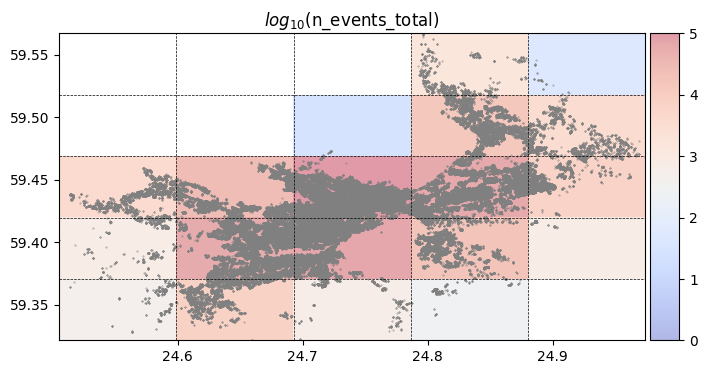

In [7]:
grid_3d = make_3d_array(gridded_data_wide, NROW, NCOL)

plot_grid(demand, grid_3d, NROW, NCOL, zmax=5)

Add a column with the total number of events to the wide dataset and plot. The plot shows that this concentration of events happens throughout the entire study period. For this reason, modelling will be done at several spatial levels: first, the total number of events will be modelled, and then single models for individual cells will be fitted.

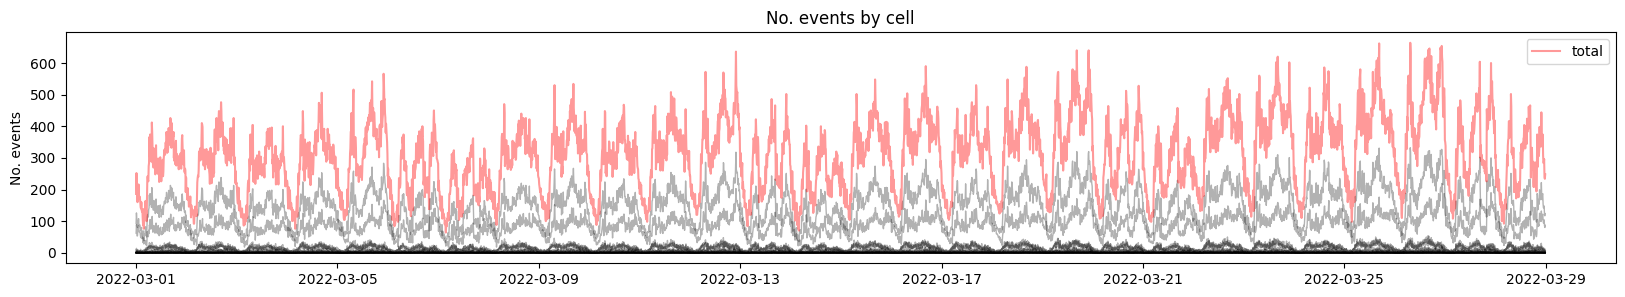

In [7]:
gridded_data_wide['n_events_total'] = gridded_data_wide.sum(axis=1)

plot_timeseries_cells(gridded_data_wide)

### **Modelling `n_events_total` - Windowing**

Data for autoregressive models must be structured in the form of a lagged dataset where features are the backshifted values of the variables ($t-1, t-2, ...$) and labels are their current values ($t$).

First, split the data into train, val and test datasets:

In [8]:
datasets = split_and_standarize_data(gridded_data_wide, f_train=0.6, f_val=0.2)

train: (2419, 26)
val: (806, 26)
test: (807, 26)


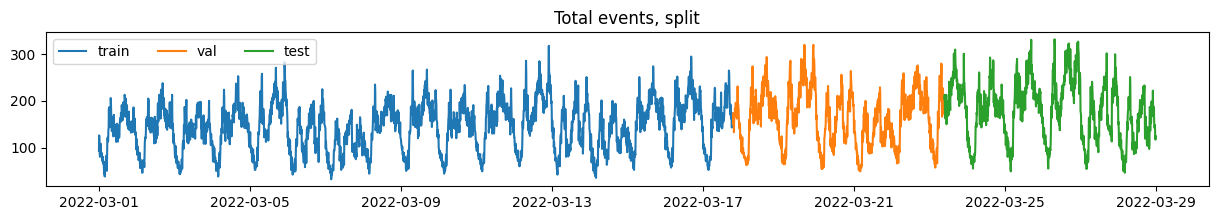

In [9]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(datasets['train_timestamps'], datasets['train_df_original']['n_events_total'], label='train')
ax.plot(datasets['val_timestamps'], datasets['val_df_original']['n_events_total'], label='val')
ax.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], label='test')
ax.set_title('Total events, split')
ax.legend(ncol=3)
plt.show()

Then, use utility class `WindowGenerator` (based on [this guide](https://www.tensorflow.org/tutorials/structured_data/time_series)) to take care of the windowing and lagging. This class and its methods return batches of data based on `tf.keras.utils.timeseries_dataset_from_array()` to be fed into the model during training. Each returned batch is of shape `(BATCH_SIZE, N_TIMESTEPS, N_FEATURES)`.

Here's an example batch using the split datasets from above, and using only the total no. of events `n_events_total` (the same can be done for individual cells): 

In [10]:
w_dummy = WindowGenerator(
    input_width=6*12, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    label_columns=['n_events_total'],
    batch_size=BATCH_SIZE)

print(f'X shape = {w_dummy.example[0].shape}')
print(f'y shape = {w_dummy.example[1].shape}')

X shape = (32, 72, 1)
y shape = (32, 1, 1)


The shapes above indicate that $X$ contains a batch of 32 samples, each with 72 (`input_width` = 6 x 12) timesteps and 1 (`label_width` = 1) feature. $y$ in turn consists of a batch of 32 samples with 1 timestep and 1 feature. That is, the model will use 72 timesteps of the specified feature to predict the next value. 

### **Modelling `n_events_total` - Modelling**

First, let's try a 1D convolutional model. Input width is the number of 10-min. timesteps from the past used as predictors and label width is 1. (i.e., we're predicting only one step into the future). The `kernel_size` of the model is made equal to the input width (stored in variable `CONV_WIDTH`) in order to get one output value per input sequence for each filter in the `Conv1D` layer. That is, each filter takes `CONV_WIDTH` timesteps and generates one value. There will be `filters` (e.g., 5) output values coming from the `Conv1D` layer, which are then combined into a single value in the final `Dense` layer, which contains only one unit.

In [11]:
CONV_WIDTH = 2*6
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=5, kernel_size=(CONV_WIDTH,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
])

w_conv = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

print(f'X shape = {w_conv.example[0].shape}')
print(f'y_pred shape = {conv(w_conv.example[0]).shape}')
print(f'y_obs shape = {w_conv.example[1].shape}')

conv(w_conv.example[0]) # build model to get number of parameters
    
print(f'Estimating {conv.count_params():,} parameters on {w_conv.train_df.shape[0]:,} datapoints')

X shape = (32, 12, 1)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 91 parameters on 2,419 datapoints


In [12]:
history_conv = compile_and_fit(conv, w_conv, max_epochs=MAX_EPOCHS, patience=20, verbose=0)

In [13]:
ypred_conv = make_ypred(conv, w_conv, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Now let's try an `LSTM` network. As for the 1D convolutional model, input sequence length is the number of 10-min. timesteps from the past used as predictors, and label width is 1 (i.e., we're predicting only one step into the future).

In [14]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=10, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

w_lstm = WindowGenerator(
    input_width=2*6, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

lstm(w_lstm.example[0]) # build model to get number of parameters

print(f'input shape = {w_lstm.example[0].shape}')
print(f'output shape = {lstm(w_lstm.example[0]).shape}')
print(f'output data shape = {w_lstm.example[1].shape}')
print(f'Estimating {lstm.count_params():,} parameters on {w_lstm.train_df.shape[0]:,} datapoints')

input shape = (32, 12, 1)
output shape = (32, 1, 1)
output data shape = (32, 1, 1)
Estimating 531 parameters on 2,419 datapoints


In [15]:
history_lstm = compile_and_fit(lstm, w_lstm, max_epochs=MAX_EPOCHS, patience=5, verbose=0)

In [16]:
ypred_lstm = make_ypred(lstm, w_lstm, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### **Modelling `n_events_total` - Results**

This is how the training curves look like for the Conv1D and the LSTM:

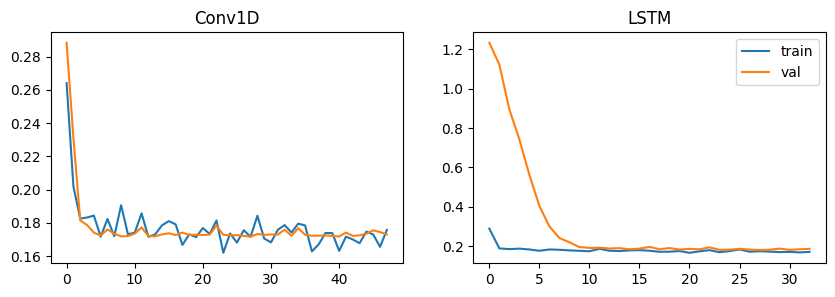

In [17]:
titles = ['Conv1D', 'LSTM']
histories = [history_conv, history_lstm]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i, (title, history) in enumerate(zip(titles, histories)):
    ax[i].plot(history.history['loss'], label='train')
    ax[i].plot(history.history['val_loss'], label='val')
    ax[i].set_title(title)
ax[1].legend()
plt.show()

Before plotting predicted vs. observed, it's important to have a baseline against which to judge model quality. Autoregressive models can be judged against different types of baselines (see [here](https://otexts.com/fpp2/simple-methods.html)). Let's use $x(t) = x(t-1)$, i.e., predictions are just the value from the previous day. Let's compute the errors for all models and also for the baseline and then plot.

In [18]:
err_abs = dict()
err_rel = dict()

ypred = {
    'conv': ypred_conv, 
    'lstm': ypred_lstm
}

for model in ypred.keys():
    err_rel[model] = 100. * (ypred[model] - datasets['test_df_original']['n_events_total'])/datasets['test_df_original']['n_events_total']
    err_abs[model] = ypred[model] - datasets['test_df_original']['n_events_total']

# add ypred for naive baseline model
ypred_naive = datasets['test_df_original']['n_events_total'][:-1].values
ytest_naive = datasets['test_df_original']['n_events_total'][1:].values
ypred['naive'] = ypred_naive
err_rel['naive'] = 100. * (ypred['naive'] - ytest_naive)/ytest_naive
err_abs['naive'] = ypred['naive'] - ytest_naive

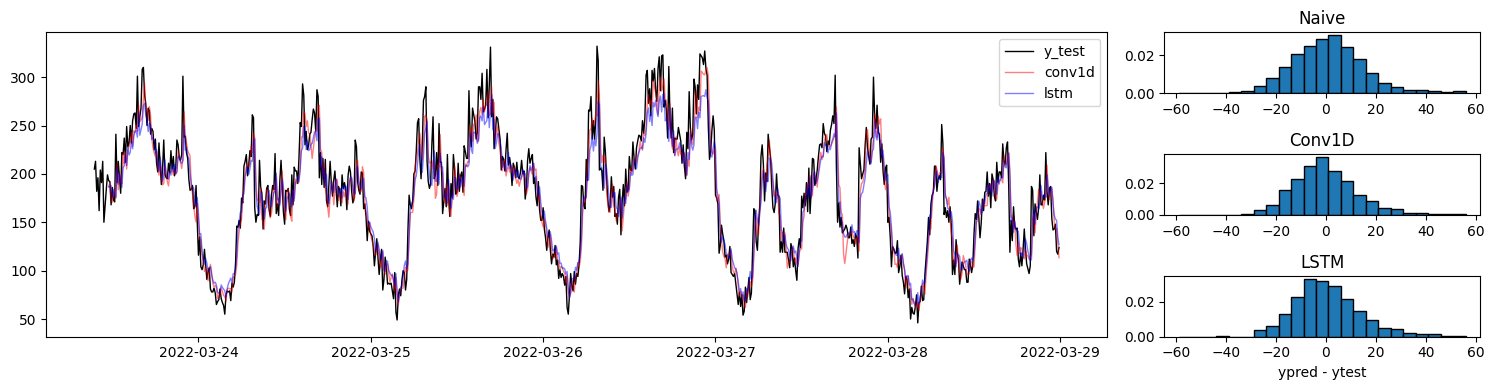

In [19]:
bins = np.arange(-59, 60, 5)
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[:, :3])
ax1.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], linewidth=1, color='black', label='y_test')
ax1.plot(datasets['test_timestamps'], ypred_conv, linewidth=1, color='red', alpha=0.5, label=f'conv1d')
ax1.plot(datasets['test_timestamps'], ypred_lstm, linewidth=1, color='blue', alpha=0.5, label=f'lstm')
ax1.legend(loc=1)
ax2 = fig.add_subplot(gs[0, 3:])
ax2.set_title('Naive')
ax2.hist(err_rel['naive'], edgecolor='black', bins=bins, density=True)
ax3 = fig.add_subplot(gs[1, 3:])
ax3.set_title('Conv1D')
ax3.hist(err_rel['conv'], edgecolor='black', bins=bins, density=True)
ax4 = fig.add_subplot(gs[2, 3:])
ax4.set_title('LSTM')
ax4.hist(err_rel['lstm'], edgecolor='black', bins=bins, density=True)
ax4.set_xlabel('ypred - ytest')
plt.tight_layout()
plt.show()

In [21]:
perc_rel_errors_below_10 = dict()
perc_rel_errors_below_10['naive'] = 100.*err_rel['naive'][err_rel['naive'] <= 10].size/err_rel['naive'].size
perc_rel_errors_below_10['conv'] = 100.*err_rel['conv'][err_rel['conv'] <= 10].size/err_rel['conv'].size
perc_rel_errors_below_10['lstm'] = 100.*err_rel['lstm'][err_rel['lstm'] <= 10].size/err_rel['lstm'].size

for model in perc_rel_errors_below_10.keys():
    print(f"{model}: {perc_rel_errors_below_10[model]:.1f} % of relative errors below 10% with {0 if model=='naive'  else globals()[model].count_params()} params")

naive: 76.2 % of relative errors below 10% with 0 params
conv: 79.2 % of relative errors below 10% with 91 params
lstm: 76.5 % of relative errors below 10% with 531 params


It's striking how good the naive baseline model is compared to both neural networks. This happens because the amount of data is small relative to what is needed to be able to use bigger networks, which when such architectures would outperform simpler models. [This notebook](https://github.com/robetatis/mlstudynotes/blob/main/naive_vs_nn.ipynb) illustrates this point.

#### **Single-cell models**

...

In [148]:
CONV_WIDTH = 1*6
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_multi = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=2, kernel_size=(CONV_WIDTH,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
])

w_conv_multi = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=datasets['train_df'],
    val_df=datasets['val_df'],
    test_df=datasets['test_df'],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total']
)

print(f'X shape = {w_conv_multi.example[0].shape}')
print(f'y_pred shape = {conv_multi(w_conv_multi.example[0]).shape}')
print(f'y_obs shape = {w_conv_multi.example[1].shape}')

conv_multi(w_conv_multi.example[0]) # build model to get number of parameters
    
print(f'Estimating {conv_multi.count_params():,} parameters on {w_conv_multi.train_df.shape[0]:,} datapoints')

X shape = (32, 6, 26)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 325 parameters on 2,419 datapoints


In [149]:
history_conv_multi = compile_and_fit(conv_multi, w_conv_multi, max_epochs=MAX_EPOCHS, patience=20, verbose=0)

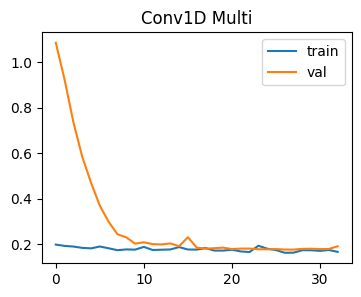

In [152]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.set_title('Conv1D Multi')
ax.legend()
plt.show()

In [199]:
ypred_conv_multi = make_ypred(conv_multi, w_conv_multi, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


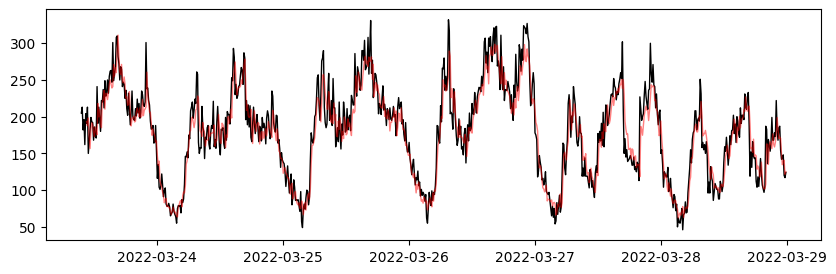

In [154]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], linewidth=1, color='black', label='y_test')
ax.plot(datasets['test_timestamps'], ypred_conv_multi, linewidth=1, color='red', alpha=0.5, label=f'conv1d')
plt.show()

In [156]:
ypred['conv_multi'] = ypred_conv_multi

for model in ypred.keys():
    err_rel[model] = 100. * (ypred[model] - datasets['test_df_original']['n_events_total'])/datasets['test_df_original']['n_events_total']
    err_abs[model] = ypred[model] - datasets['test_df_original']['n_events_total']

perc_rel_errors_below_10['conv_multi'] = 100.*err_rel['conv_multi'][err_rel['conv_multi'] <= 10].size/err_rel['conv_multi'].size

for model in perc_rel_errors_below_10.keys():
    print(f'{model}: {perc_rel_errors_below_10[model]:.1f} % of relative errors below 10% with {globals()[model].count_params()} params')

conv: 80.7 % of relative errors below 10% with 91 params
conv_multi: 81.5 % of relative errors below 10% with 325 params
